In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re
import glob
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from datetime import datetime, timedelta
from collections import defaultdict
from multiprocessing import Manager
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

pd.set_option('display.max_columns', None)

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "9g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .appName('exploration') \
    .getOrCreate()

24/10/15 23:49:37 WARN Utils: Your hostname, Alans-MacBook-Air-4.local resolves to a loopback address: 127.0.0.1; using 192.168.0.52 instead (on interface en0)
24/10/15 23:49:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/15 23:49:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
transactions1 = spark.read.parquet("../data/landing/transactions/transactions_20210228_20210827_snapshot")
transactions2 = spark.read.parquet("../data/landing/transactions/transactions_20210828_20220227_snapshot")
transactions3 = spark.read.parquet("../data/landing/transactions/transactions_20220228_20220828_snapshot")

transactions = transactions1.union(transactions2).union(transactions3)

transactions = transactions.withColumn('user_id', F.col('user_id').cast(StringType()))
transactions = transactions.withColumn('merchant_abn', F.col('merchant_abn').cast(StringType()))

transactions.show(truncate=False)

+-------+------------+------------------+------------------------------------+--------------+
|user_id|merchant_abn|dollar_value      |order_id                            |order_datetime|
+-------+------------+------------------+------------------------------------+--------------+
|18478  |62191208634 |63.255848959735246|949a63c8-29f7-4ab0-ada4-99ac50a88952|2021-08-20    |
|2      |15549624934 |130.3505283105634 |6a84c3cf-612a-4574-835b-144a47353eff|2021-08-20    |
|18479  |64403598239 |120.15860593212783|b10dcc33-e53f-4254-863c-de5266810cbc|2021-08-20    |
|3      |60956456424 |136.6785200286976 |0f09c5a5-784e-4477-b049-8ee4dd069b7b|2021-08-20    |
|18479  |94493496784 |72.96316578355305 |f6c78c1a-4600-4c5f-8e97-6e9eb534b586|2021-08-20    |
|3      |76819856970 |448.529684285612  |5ace6a24-cdf0-4aa3-b571-1d9406b352b5|2021-08-20    |
|18479  |67609108741 |86.4040605836911  |d0e180f0-cb06-42a3-bd1a-c47dca15bc55|2021-08-20    |
|3      |34096466752 |301.5793450525113 |6fb1ff48-24bb-4f97-

In [3]:
consumer_fraud = spark.read.option("header", True).csv("../data/landing/tables/consumer_fraud_probability.csv")
consumer_fraud = consumer_fraud.withColumn('order_datetime', F.col('order_datetime').cast(DateType()))
consumer_fraud = consumer_fraud.withColumn('fraud_probability', F.col('fraud_probability').cast('double'))

consumer_details = spark.read.parquet("../data/landing/tables/consumer_user_details.parquet")
consumer_details = consumer_details.withColumn('user_id', F.col('user_id').cast('string'))
consumer_details = consumer_details.withColumn('consumer_id', F.col('consumer_id').cast('string'))

merchant_fraud = spark.read.option("header", True).csv("../data/landing/tables/merchant_fraud_probability.csv")
merchant_fraud = merchant_fraud.withColumnRenamed('fraud_probability', 'merchant_fraud_probability')
merchant_fraud = merchant_fraud.withColumn('merchant_fraud_probability', F.col('merchant_fraud_probability').cast('double'))

tbl_consumer = spark.read.option("header", True).option("delimiter", "|").csv("../data/landing/tables/tbl_consumer.csv")

tbl_consumer = tbl_consumer.filter(F.col("state").isin(["NSW", "WA", "NT", "VIC", "TAS", "QLD", "SA",   "ACT"]))
tbl_consumer = tbl_consumer.filter(F.col("gender").isin(["Female", "Male", "Undisclosed"]))
tbl_consumer = tbl_consumer.withColumn("postcode", tbl_consumer["postcode"].cast(IntegerType()))
tbl_consumer = tbl_consumer.withColumnRenamed("name", "consumer_name")

In [4]:
tbl_merchants = spark.read.parquet("../data/landing/tables/tbl_merchants.parquet")
tbl_merchants = tbl_merchants.withColumn('tags', F.regexp_replace('tags', r'\(', r'\[')) \
    .withColumn('tags', F.lower(F.regexp_replace('tags', r'\)', r'\]')))

tbl_merchants = tbl_merchants.withColumn('tags1', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=1)))
tbl_merchants = tbl_merchants.withColumn('tags2', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=2)))
tbl_merchants = tbl_merchants.withColumn('tags3', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=3)).cast(DoubleType()))

tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "\\s+", " "))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", except appliances", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "rent al", "rental"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ":", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " -", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " shops", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " services", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " service", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " and", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", sales", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " ,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",]", "]"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\[", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\]", ""))

tbl_merchants = tbl_merchants.withColumnRenamed('tags3', 'take_rate')
tbl_merchants = tbl_merchants.withColumnRenamed('tags2', 'type')
tbl_merchants = tbl_merchants.withColumnRenamed("name", "merchant_name")
tbl_merchants = tbl_merchants.drop('tags')
tbl_merchants = tbl_merchants.withColumnRenamed('tags1', 'tags')

tbl_merchants.show(truncate=False)

+------------------------------------+------------+----------------------------------------------------------------+----+---------+
|merchant_name                       |merchant_abn|tags                                                            |type|take_rate|
+------------------------------------+------------+----------------------------------------------------------------+----+---------+
|Felis Limited                       |10023283211 |furniture, home furnishings, equipment, manufacturers           |e   |0.18     |
|Arcu Ac Orci Corporation            |10142254217 |cable, satellite, other pay television, radio                   |b   |4.22     |
|Nunc Sed Company                    |10165489824 |jewelry, watch, clock, silverware                               |b   |4.4      |
|Ultricies Dignissim Lacus Foundation|10187291046 |watch, clock, jewelry repair                                    |b   |3.29     |
|Enim Condimentum PC                 |10192359162 |music, musical instrument

In [5]:
full_transactions = transactions.join(consumer_details, on="user_id",how="left") \
                   .join(tbl_consumer, on="consumer_id",how="left") \
                   .join(consumer_fraud, on=["user_id", "order_datetime"],how="left") \
                   .join(tbl_merchants, on="merchant_abn",how="left") \
                   .join(merchant_fraud, on=["order_datetime", "merchant_abn"], how="left")

full_transactions.show(truncate=False)

+--------------+------------+-------+-----------+-------------------+------------------------------------+---------------+--------------------------+-----+--------+------+-----------------+---------------------------------+----------------------------------------------------------------+----+---------+--------------------------+
|order_datetime|merchant_abn|user_id|consumer_id|dollar_value       |order_id                            |consumer_name  |address                   |state|postcode|gender|fraud_probability|merchant_name                    |tags                                                            |type|take_rate|merchant_fraud_probability|
+--------------+------------+-------+-----------+-------------------+------------------------------------+---------------+--------------------------+-----+--------+------+-----------------+---------------------------------+----------------------------------------------------------------+----+---------+--------------------------+
|2022-0

In [6]:
# Include shape data
postcodes = gpd.read_file("../data/landing/POA_2021_AUST_GDA2020_SHP")
postcodes = postcodes.to_crs(epsg='4326')

postcodes['lon'] = postcodes.geometry.centroid.x
postcodes['lat'] = postcodes.geometry.centroid.y
postcodes = postcodes.drop(columns='geometry')
postcodes = postcodes.loc[:, ['POA_CODE21', 'AREASQKM21', 'SHAPE_Leng', 'SHAPE_Area', 'lon', 'lat']]
postcodes = postcodes.rename(columns={'POA_CODE21': 'postcode'})

postcodes = spark.createDataFrame(postcodes)

full_transactions = full_transactions.join(postcodes, on='postcode')
full_transactions.show(truncate=False)

/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_97508/463735460.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  postcodes['lon'] = postcodes.geometry.centroid.x
/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_97508/463735460.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  postcodes['lat'] = postcodes.geometry.centroid.y


+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------------+----------------------------------------------------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name|address        |state|gender|fraud_probability|merchant_name                      |tags                                                            |type|take_rate|merchant_fraud_probability|AREASQKM21|SHAPE_Leng   |SHAPE_Area    |lon               |lat                |
+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------

In [7]:
# Combine the census data into a single dataframe, by postcode
# https://www.abs.gov.au/census/find-census-data/datapacks?release=2021&product=GCP&geography=SA2&header=S
TABLES = [
    '2021Census_G02_AUST_POA.csv',
    '2021Census_G04A_AUST_POA.csv',
    '2021Census_G04B_AUST_POA.csv'
]
POSTCODE_COLUMN = 'POA_CODE_2021'
SELECTED_COLUMNS = [
    POSTCODE_COLUMN,
    'Median_age_persons', 
    'Median_tot_fam_inc_weekly', 
    'Median_tot_hhd_inc_weekly', 
    'Average_household_size', 
    'Tot_M', 
    'Tot_P', 
    'Tot_F'
]

census_df = None
for table in TABLES:
    df = spark.read.options(header=True) \
        .csv(f"../data/landing/2021_GCP_POA_for_AUS_short-header/2021 Census GCP Postal Areas for AUS/{table}")

    if census_df is None:
        census_df = df
    else:
        census_df = census_df.join(df, POSTCODE_COLUMN).drop(df[POSTCODE_COLUMN])

census_df = census_df.withColumn(POSTCODE_COLUMN, F.regexp_replace(F.col(POSTCODE_COLUMN), "(\D)", ""))
census_df = census_df.select(*SELECTED_COLUMNS)
for column in SELECTED_COLUMNS[1:]:
    census_df = census_df.withColumn(column, F.col(column).cast(DoubleType()))
census_df = census_df.withColumnRenamed("POA_CODE_2021", "postcode")

full_transactions = full_transactions.join(census_df, on='postcode', how="left")

census_df.summary().show()

24/10/15 23:50:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-------------------------+-------------------------+----------------------+-----------------+-----------------+-----------------+
|summary|          postcode|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|            Tot_M|            Tot_P|            Tot_F|
+-------+------------------+------------------+-------------------------+-------------------------+----------------------+-----------------+-----------------+-----------------+
|  count|              2643|              2643|                     2643|                     2643|                  2643|             2643|             2643|             2643|
|   mean| 4169.567915247824| 43.38441165342414|       1974.9659477866062|        1607.308361710178|    2.4601210745365076|4746.547862277715|9618.901248581158|4872.346954218691|
| stddev|1529.6617635065575| 7.489670852428322|        643.3465903597508|        531.8668354868943|   0.34928106179

In [8]:
retail_df = pd.read_excel("../data/landing/850103.xlsx", sheet_name="Data1", index_col=0)

states = ["NSW", "VIC", "QLD", "SA", "WA", "TAS", "NT", "ACT", "Total"]
trend_types = ["original", "seasonal", "trend"]
retail_columns = []
for trend_type in trend_types:
    for state in states:
        retail_columns.append(f"{state}_{trend_type}")

# Add date column
retail_df.columns = retail_columns
retail_df = retail_df.iloc[11:,:]
retail_df.index = pd.to_datetime(retail_df.index).strftime("%Y-%m")
retail_df['date'] = retail_df.index
retail_df.to_parquet("../data/raw/retail_sales.parquet", index=False)
retail_df

,NSW_original,VIC_original,QLD_original,SA_original,WA_original,TAS_original,NT_original,ACT_original,Total_original,NSW_seasonal,VIC_seasonal,QLD_seasonal,SA_seasonal,WA_seasonal,TAS_seasonal,NT_seasonal,ACT_seasonal,Total_seasonal,NSW_trend,VIC_trend,QLD_trend,SA_trend,WA_trend,TAS_trend,NT_trend,ACT_trend,Total_trend,date
1982-06,1234.2,887,494.1,277.2,301.5,77.5,NaN,55.3,3357.8,1309.8,952.9,518.6,288.9,321.2,81,NaN,58.3,3561.5,1305.1,946.3,515.7,291.8,317.8,81.9,NaN,57.7,3547,1982-06
1982-07,1265,921.3,515.6,296.1,316.4,82.7,NaN,56.3,3486.8,1291.9,955.9,518.1,296.2,320.4,83.7,NaN,56.8,3553.9,1302.4,954.3,517.3,296.3,319.1,82.2,NaN,58.2,3560.6,1982-07
1982-08,1217.6,883.2,501.4,288.4,300.5,78.1,NaN,55.4,3355.9,1314.4,950.7,521.4,303.6,318.5,83.3,NaN,58.9,3581.8,1298.1,963.6,518,301.1,320.4,82.4,NaN,58.9,3573.6,1982-08
1982-09,1244.9,917.9,517.7,293,312.3,79.1,NaN,57.5,3454.3,1292.4,971.9,521,303.7,319.6,82.5,NaN,59,3581.2,1293.1,974.1,517.9,306.2,321.6,82.4,NaN,60,3586.7,1982-09
1982-10,1264.2,983.3,504.2,307.9,318.7,78.7,NaN,61.9,3551.5,1289.4,987.7,510.9,310.8,322.2,81.1,NaN,61.6,3595.6,1293.2,985.5,518.1,311.3,322.6,82.5,NaN,61.2,3605.8,1982-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03,10873.5,9101.1,7185.7,2292.9,3975.6,721,313.8,673.1,35136.7,11082.4,9195.7,7362.9,2311.9,4034.1,718.2,331.3,673.8,35710.3,11151.2,9210.3,7363,2317.9,4032.8,720.4,329.7,673,35798.2,2024-03
2024-04,10639.8,8820.1,6907.1,2218.8,3800.2,682.8,311,641.2,34020.9,11183.2,9167,7361,2324.2,4045.3,718.3,330.9,673.4,35803.3,11164.9,9230.6,7379.6,2320.4,4059.1,720.3,331.3,675,35881.3,2024-04
2024-05,11090.6,9144.7,7206.6,2298.7,4004.9,707.1,335.3,667.6,35455.4,11179,9265.4,7403.9,2321.7,4096.2,722.4,332.2,677.6,35998.4,11179.7,9254.4,7401.6,2322.8,4087.5,720.2,333,676.9,35976,2024-05
2024-06,10777.4,8937.4,7163.6,2229,3973.2,678.1,346.4,661.2,34766.2,11217.2,9306.8,7439.5,2328.8,4129.9,722.5,334.8,682.6,36162.1,11195.8,9281.9,7426,2325.3,4116.3,720.1,334.7,678.8,36078.9,2024-06


In [9]:
retail_df = spark.read.parquet("../data/raw/retail_sales.parquet")
retail_df = retail_df.withColumn("month", F.month("date"))
retail_df = retail_df.withColumn("year", F.year("date"))
retail_df = retail_df.drop('date')
retail_df = retail_df.select([col for col in retail_df.columns if not col.endswith('trend')])
retail_sales = {(row['year'], row['month']): row['Total_seasonal'] for row in retail_df.collect()}

full_transactions = full_transactions.withColumn("month", F.month("order_datetime"))
full_transactions = full_transactions.withColumn("year", F.year("order_datetime"))
full_transactions = full_transactions.join(retail_df, on=['month', 'year'], how='left')
full_transactions.show(truncate=False)

+-----+----+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------------+----------------------------------------------------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name|address        |state|gender|fraud_probability|merchant_name                      |tags                     

In [10]:
# Save combined transactions 
full_transactions.write.mode("overwrite").parquet("../data/curated/transactions.parquet")

RMSE: 2.610635215679272


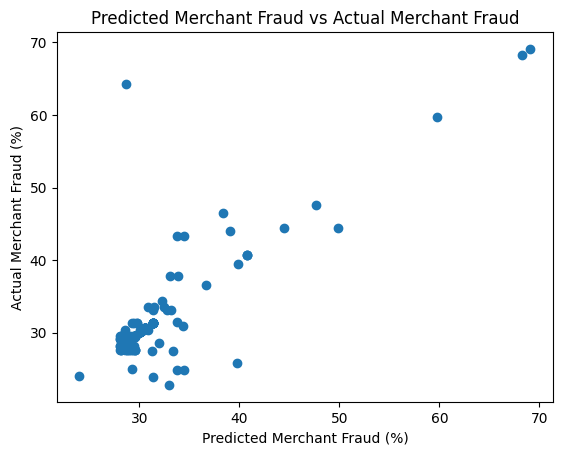

In [11]:
# Show testing of imputing merchant fraud probabilities
transactions = spark.read.parquet("../data/curated/transactions.parquet")

categories = transactions.select('tags').distinct().toPandas().dropna().astype("string")['tags'].to_list()
transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).toPandas()

X = transactions.drop('merchant_fraud_probability', axis=1)
y = transactions['merchant_fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

columns = list(X.columns.values)

preprocessor = ColumnTransformer(
    transformers=[
        ('tags', Pipeline([
            ('onehot', OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('tags')]), # tags
        ('state', Pipeline([
            ('onehot', OneHotEncoder(categories=[['NSW', 'VIC', 'TAS', 'QLD', 'WA', 'SA', 'NT', 'ACT']], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('state')]), # state
        ('dollar_value', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('dollar_value')]), # dollar value
        ('take_rate', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('take_rate')]) # take rate
    ]
)

knn = KNeighborsRegressor(n_neighbors=3, weights='distance', p=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

pipeline.fit(X_train, y_train)

# Display graph of predicted vs actual
plt.scatter(pipeline.predict(X_test), y_test)
plt.title("Predicted Merchant Fraud vs Actual Merchant Fraud")
plt.ylabel('Actual Merchant Fraud (%)')
plt.xlabel("Predicted Merchant Fraud (%)")
print(f"RMSE: {root_mean_squared_error(y_test, pipeline.predict(X_test))}")

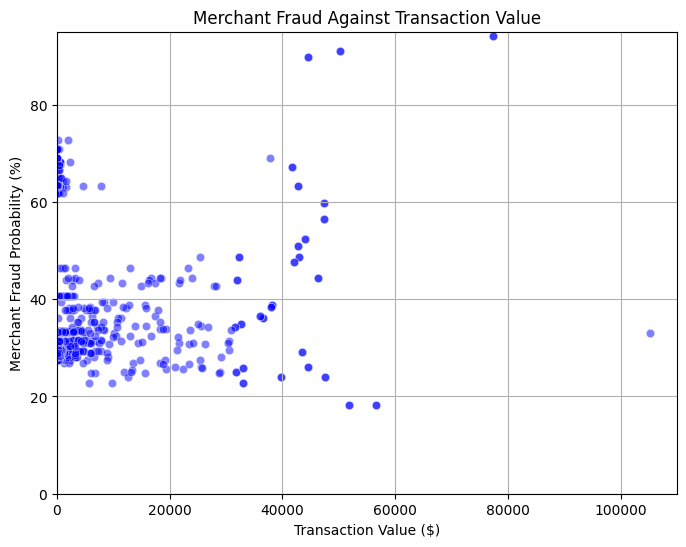

In [12]:
# Show merchant fraud against the transaction value, one of the factors in the KNN model
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(transactions, x='dollar_value', y='merchant_fraud_probability', alpha=0.5, color='blue')
plt.title("Merchant Fraud Against Transaction Value")
plt.ylabel('Merchant Fraud Probability (%)')
plt.xlabel("Transaction Value ($)")

plt.xlim((0, 110000))
plt.ylim((0, 95))
plt.grid()
plt.show()

In [27]:
# Refit on the full transactions, and impute merchant fraud
pipeline.fit(X, y)
transactions = pd.read_parquet("../data/curated/transactions.parquet")

mask = transactions['merchant_fraud_probability'].isna()

transactions_to_predict = transactions.loc[mask, :]
X_to_predict = transactions_to_predict.drop('merchant_fraud_probability', axis=1)

transactions.loc[mask, 'merchant_fraud_probability'] = pipeline.predict(X_to_predict)
transactions.to_parquet("../data/curated/transactions_merchant.parquet")

RMSE: 7.25234395698151


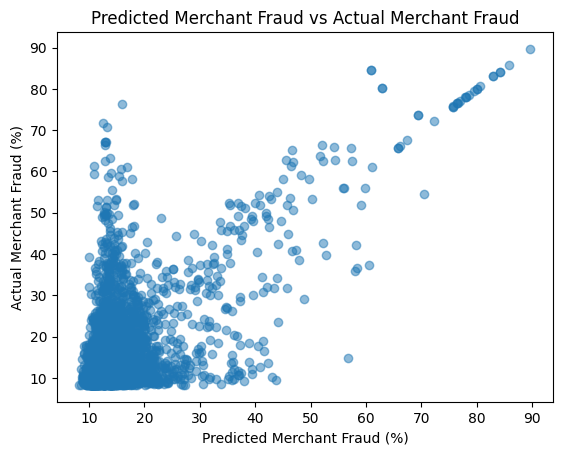

In [31]:
# Impute consumer fraud probabilities
transactions = spark.read.parquet("../data/curated/transactions_merchant.parquet")

categories = transactions.select('tags').distinct().toPandas().dropna().astype("string")['tags'].to_list()
transactions = transactions.where(F.col("fraud_probability").isNotNull()).toPandas()

X = transactions.drop('fraud_probability', axis=1)
y = transactions['fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

columns = list(X.columns.values)

preprocessor = ColumnTransformer(
    transformers=[
        ('tags', Pipeline([
            ('onehot', OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('tags')]), # tags
        ('state', Pipeline([
            ('onehot', OneHotEncoder(categories=[['NSW', 'VIC', 'TAS', 'QLD', 'WA', 'SA', 'NT', 'ACT']], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('state')]), # state
        ('dollar_value', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('dollar_value')]), # dollar value
        ('take_rate', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('take_rate')]) # take rate
    ]
)

knn = KNeighborsRegressor(n_neighbors=int(math.sqrt(len(transactions)) / 2), weights='distance', p=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

X = transactions.drop('fraud_probability', axis=1)
y = transactions['fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

pipeline.fit(X_train, y_train)

# Display graph of predicted vs actual
plt.scatter(pipeline.predict(X_test), y_test, alpha=0.5)
plt.title("Predicted Merchant Fraud vs Actual Merchant Fraud")
plt.ylabel('Actual Merchant Fraud (%)')
plt.xlabel("Predicted Merchant Fraud (%)")
print(f"RMSE: {root_mean_squared_error(y_test, pipeline.predict(X_test))}")

In [32]:
# Impute missing consumer fraud values
pipeline.fit(X, y)
transactions = pd.read_parquet("../data/curated/transactions_merchant.parquet")

mask = transactions['fraud_probability'].isna()

transactions_to_predict = transactions.loc[mask, :]
X_to_predict = transactions_to_predict.drop('fraud_probability', axis=1)

transactions.loc[mask, 'fraud_probability'] = pipeline.predict(X_to_predict)
transactions.to_parquet("../data/curated/transactions_imputed.parquet")

In [11]:
# Add features to get transactions ready to pass to model
transactions = spark.read.parquet("../data/curated/transactions_imputed.parquet")
transactions = transactions.withColumn('expected_revenue', 
                                       transactions.dollar_value
                                       * (1.0 - transactions.merchant_fraud_probability / 100.0) 
                                       * (1.0 - transactions.fraud_probability / 100.0) 
                                       * transactions.take_rate / 100.0)
transactions = transactions.withColumn('day_of_week', F.dayofweek('order_datetime'))
transactions = transactions.withColumn('day_of_month', F.dayofmonth('order_datetime'))
transactions = transactions.withColumn('day_of_year', F.dayofyear('order_datetime'))
transactions = transactions.withColumn('month', F.month('order_datetime'))

transactions = transactions.withColumn(
    "is_holiday",
    F.when(F.col("order_datetime").isin([
        '2021-11-26',
        '2021-11-27',
        '2021-11-28',
        '2021-11-29',
        '2021-12-24',
        '2021-12-25',
        '2021-12-26',
    ]), F.lit(1)).otherwise(F.lit(0))
)

transactions = transactions.withColumn(
    "seasonal_sales",
    F.when(F.col("state") == "NSW", F.col("NSW_seasonal"))
     .when(F.col("state") == "VIC", F.col("VIC_seasonal"))
     .when(F.col("state") == "QLD", F.col("QLD_seasonal"))
     .when(F.col("state") == "SA", F.col("SA_seasonal"))
     .when(F.col("state") == "WA", F.col("WA_seasonal"))
     .when(F.col("state") == "TAS", F.col("TAS_seasonal"))
     .when(F.col("state") == "NT", F.col("NT_seasonal"))
     .when(F.col("state") == "ACT", F.col("ACT_seasonal"))
     .otherwise(None)
)

transactions = transactions.withColumn(
    "original_sales",
    F.when(F.col("state") == "NSW", F.col("NSW_original"))
     .when(F.col("state") == "VIC", F.col("VIC_original"))
     .when(F.col("state") == "QLD", F.col("QLD_original"))
     .when(F.col("state") == "SA", F.col("SA_original"))
     .when(F.col("state") == "WA", F.col("WA_original"))
     .when(F.col("state") == "TAS", F.col("TAS_original"))
     .when(F.col("state") == "NT", F.col("NT_original"))
     .when(F.col("state") == "ACT", F.col("ACT_original"))
     .otherwise(None)
)

transactions = transactions.withColumnRenamed("Total_seasonal", "total_seasonal_sales")
transactions = transactions.withColumnRenamed("Total_original", "total_original_sales")
transactions = transactions.select([col for col in transactions.columns if not col.endswith('original')])
transactions = transactions.select([col for col in transactions.columns if not col.endswith('seasonal')])

transactions.write.mode('overwrite').parquet("../data/curated/transactions_preprocessed.parquet")
transactions.show()

+-----+----+--------+--------------+------------+-------+-----------+------------------+--------------------+-------------+---------------+-----+------+------------------+--------------------+--------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+--------------------+--------------------+--------------------+-----------+------------+-----------+----------+--------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|consumer_name|        address|state|gender| fraud_probability|       merchant_name|                tags|type|take_rate|merchant_fraud_probability|AREASQKM21|   SHAPE_Leng|    SHAPE_Area|               lon|                lat|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average

In [18]:
from pyspark.sql.window import Window
from pyspark.sql import DataFrame

transactions = spark.read.parquet("../data/curated/transactions_preprocessed.parquet")

def skewness_udf(column):
    return (F.mean(column) - F.median(column)) / F.stddev(column)

window_spec = Window.partitionBy("merchant_abn").orderBy("order_datetime")

agg_df = transactions.groupBy("merchant_abn").agg(
    F.expr("percentile_approx(fraud_probability, 0.5)").alias("fraud_probability_median"),
    skewness_udf(F.col("fraud_probability")).alias("fraud_probability_skewness"),
    F.expr("percentile_approx(dollar_value, 0.5)").alias("dollar_value_median"),
    F.expr("percentile_approx(expected_revenue, 0.5)").alias("expected_revenue_median"),
    skewness_udf(F.col("dollar_value")).alias("dollar_value_skewness"),
    F.count("merchant_abn").alias("record_count"),
    F.first("tags").alias("tags"),
    F.first("take_rate").alias("take_rate"),
    F.mean("merchant_fraud_probability").alias("merchant_fraud_probability"),
    F.mean("dollar_value").alias("mean_dollar_value"),
)

agg_df.show()

+------------+------------------------+--------------------------+-------------------+-----------------------+---------------------+------------+--------------------+---------+--------------------------+------------------+
|merchant_abn|fraud_probability_median|fraud_probability_skewness|dollar_value_median|expected_revenue_median|dollar_value_skewness|record_count|                tags|take_rate|merchant_fraud_probability| mean_dollar_value|
+------------+------------------------+--------------------------+-------------------+-----------------------+---------------------+------------+--------------------+---------+--------------------------+------------------+
| 10441711491|      13.981469844702758|       0.38977680993708913|  4184.883294138098|     146.31870423556205|   0.4506005262127406|           3|motor vehicle sup...|     5.77|        29.555244690425024| 5751.207887182689|
| 10487253336|      13.091596850582814|        0.2043608445425334| 359.87222862385426|      7.37545284454379

/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_46940/3827805253.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Med price, Med sales' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[df['cluster'] == 0, 'cluster'] = "Med price, Med sales"
/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_46940/3827805253.py:31: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(df, x='record_count', y=y, hue='cluster', palette=sns.color_palette(), alpha=0.5, s=30)


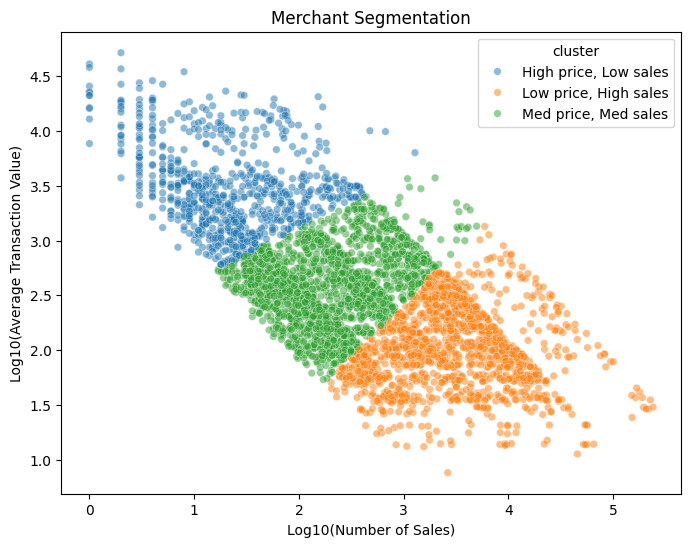

In [15]:
# Cluster into merchant segments
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

y = 'mean_dollar_value'
df = agg_df.toPandas()
df = df.fillna(0)
df['record_count'] = np.log10(df['record_count'])
df[y] = np.log10(df[y])

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=0))
])

df['cluster'] = pipeline.fit_predict(df[[
    'record_count', 
    y
]])

df.loc[df['cluster'] == 0, 'cluster'] = "Med price, Med sales"
df.loc[df['cluster'] == 1, 'cluster'] = "High price, Low sales"
df.loc[df['cluster'] == 2, 'cluster'] = "Low price, High sales"

plt.figure(figsize=(8, 6))
sns.scatterplot(df, x='record_count', y=y, hue='cluster', palette=sns.color_palette(), alpha=0.5, s=30)
plt.title("Merchant Segmentation")
plt.ylabel('Log10(Average Transaction Value)')
plt.xlabel("Log10(Number of Sales)")
plt.show()

clusters = spark.createDataFrame(df).select('merchant_abn', 'cluster')

Validation RMSE: 22.523053969202767


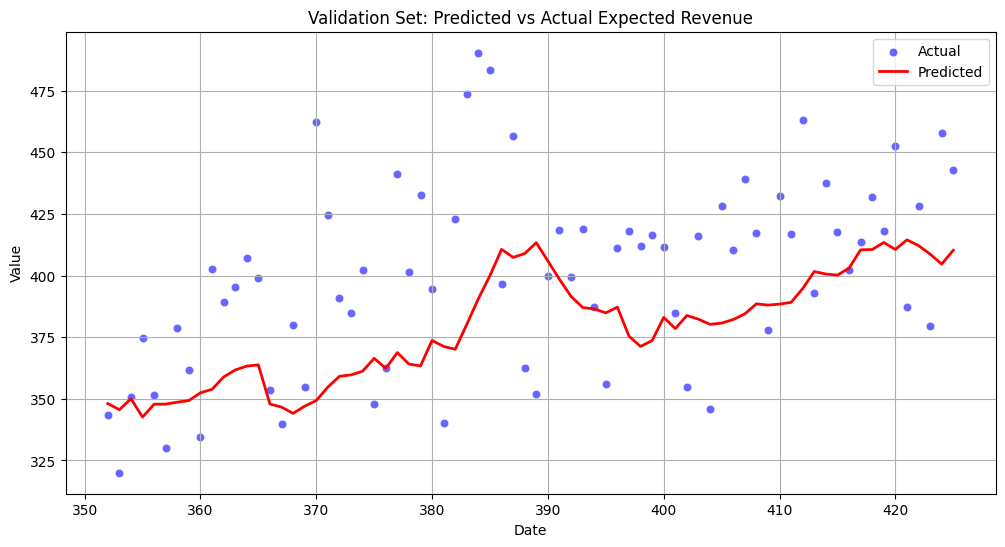

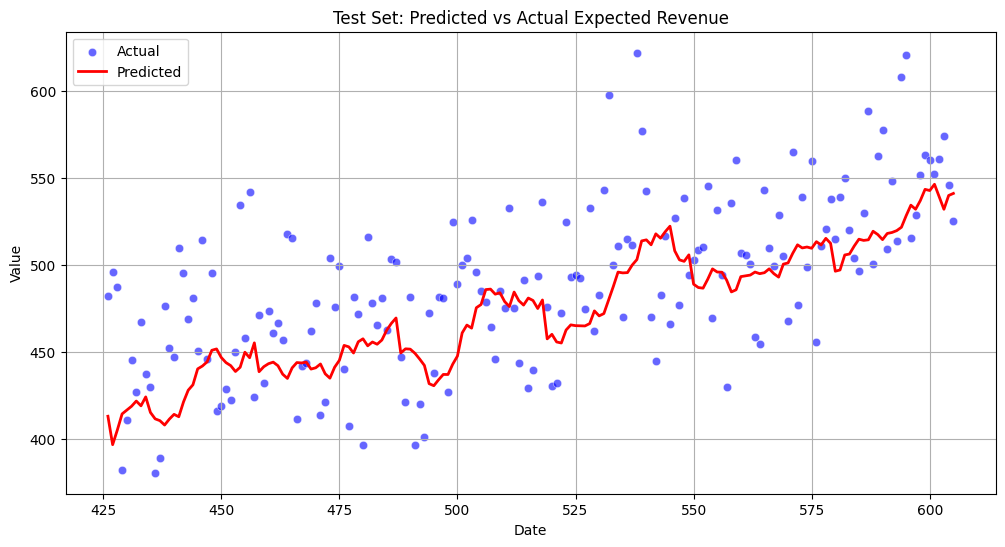

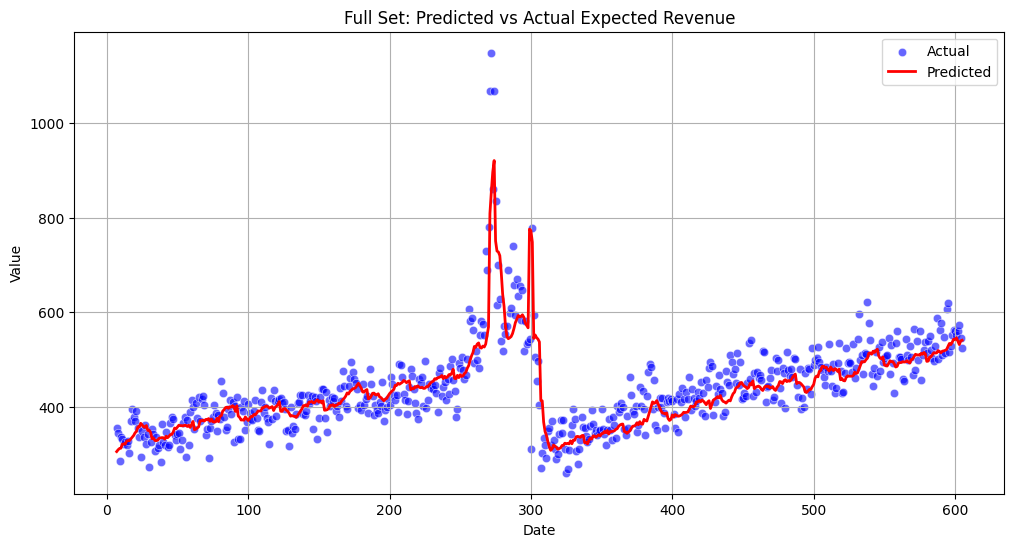

In [14]:
# Show the validation, test and training set for the XGBoost model for a single merchant

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error

merchant_abn = '89726005175'

retail_df = spark.read.parquet("../data/raw/retail_sales.parquet")
retail_df = retail_df.withColumn("month", F.month("date"))
retail_df = retail_df.withColumn("year", F.year("date"))
retail_df = retail_df.drop('date')
retail_df = retail_df.select([col for col in retail_df.columns if not col.endswith('trend')])
result = retail_df.collect()

retail_sales = {(row['year'], row['month']): (row['Total_original'], row['Total_seasonal']) for row in result}

transactions = spark.read.parquet("../data/curated/transactions_preprocessed.parquet")
transactions = transactions.groupBy("merchant_abn", "order_datetime").agg(
    F.sum("expected_revenue").alias("expected_revenue"),
    F.mean("fraud_probability").alias("mean_fraud_probability"),
    F.mean("dollar_value").alias("mean_dollar_value"),
    F.count("merchant_abn").alias("num_sales"),
    F.first("tags").alias("tags"),
    F.first("take_rate").alias("take_rate"),
    F.mean("merchant_fraud_probability").alias("mean_merchant_fraud_probability"),
    F.mean("Median_age_persons").alias("median_age"),
    F.mean("Median_tot_fam_inc_weekly").alias("median_family_income"),
    F.mean("Median_tot_hhd_inc_weekly").alias("median_household_income"),
    F.mean("Average_household_size").alias("mean_household_size"),
    F.mean("Tot_P").alias("postcode_population"),
    F.first("day_of_week").alias("day_of_week"),
    F.first("day_of_month").alias("day_of_month"),
    F.first("day_of_year").alias("day_of_year"),
    F.first("month").alias("month"),
    F.first("year").alias("year"),
    F.mean("seasonal_sales").alias("seasonal_sales"),
    F.mean("original_sales").alias("original_sales"),
    F.first("total_seasonal_sales").alias("total_seasonal_sales"),
    F.first("total_original_sales").alias("total_original_sales"),
    F.first("is_holiday").alias("is_holiday"),
)

transactions = transactions.sort(F.col("order_datetime"), F.col("merchant_abn"))

# Select a merchant
df = transactions.where(F.col("merchant_abn") == merchant_abn)
df = df.toPandas()

# Create lagged and moving averages of a column
def create_lagged_features(df, n_lags, column):
    df[f'moving_average_{column}'] = 0
    for lag in range(1, n_lags + 1):
        df[f'lag_{column}_{lag}'] = df[column].shift(lag)
        df[f'moving_average_{column}'] += df[f'lag_{column}_{lag}']
    df[f'moving_average_{column}'] /= n_lags
    return df


def lag_feature(df, n_lags, column):
    df[column] = df[column].shift(n_lags)
    return df


def create_test_train_validate_split(X, y, train_size=0.7, val_size=0.15):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=(1 - train_size), shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(val_size / (train_size + val_size)), shuffle=False)

    return X_train, y_train, X_val, y_val, X_test, y_test


def add_date_columns(df):
    df['day_of_year'] = df['order_datetime'].dt.dayofyear
    df['day_of_month'] = df['order_datetime'].dt.day
    df['month'] = df['order_datetime'].dt.month
    df['is_holiday'] = df['order_datetime'].isin(pd.to_datetime([
        '2021-11-26',
        '2021-11-27',
        '2021-11-28',
        '2021-11-29',
        '2021-12-24',
        '2021-12-25',
        '2021-12-26',

        '2022-11-25',
        '2022-11-26',
        '2022-11-27',
        '2022-11-28',
        '2022-12-24',
        '2022-12-25',
        '2022-12-26',
    ]))
    return df


def predict_single_step(model, df, prediction_columns, imputing_columns, n_lags):
    last_row = df.tail(1)

    # Add date columns
    next_row = pd.DataFrame()
    next_row['order_datetime'] = [pd.to_datetime(last_row['order_datetime'].values[-1] + pd.Timedelta(days=1))]

    next_row = add_date_columns(next_row)

    # Add sales columns
    year = next_row['order_datetime'].dt.year.values[-1]
    month = next_row['order_datetime'].dt.month.values[-1]
    next_row['total_original_sales'], next_row['total_seasonal_sales'] = retail_sales[(year, month)]

    # Add moving average (prediction) columns
    for col in prediction_columns:
        next_row[f'moving_average_{col}'] = df.tail(n_lags)[col].mean()

    # Add columns imputed by mean
    for col in imputing_columns:
        next_row[col] = df[col].mean()

    next_row = next_row.sort_index(axis=1)
    y_pred = model.predict(next_row.drop(prediction_columns + ['order_datetime'], axis=1, errors='ignore'))

    for i, col in enumerate(prediction_columns):
        next_row[col] = y_pred[0][i]
    
    next_row = next_row.sort_index(axis=1)
    return pd.concat([df, next_row])


# Get the original and seasonal sales from a list of years and months
def get_retail_sales(years, months):
    original_sales = []
    seasonal_sales = []
    for i in range(len(years)):
        original, seasonal = retail_sales[(years[i], months[i])]
        original_sales.append(original)
        seasonal_sales.append(seasonal)
    return original_sales, seasonal_sales


def plot_predictions(actual, predicted, title='Predicted vs Actual'):
    plt.figure(figsize=(12, 6))
    
    sns.scatterplot(x=actual.index, y=actual, label='Actual', color='blue', alpha=0.6)
    sns.lineplot(x=actual.index, y=predicted, label='Predicted', color='red', linestyle='-', linewidth=2)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()


n_lags = 7
prediction_period = 90
train_size = 0.7
val_size = 0.15

# Only use moving averages of these features to avoid overfitting to the current day/day before
df = create_lagged_features(df, n_lags, 'expected_revenue')
df = create_lagged_features(df, n_lags, 'num_sales')
df = create_lagged_features(df, n_lags, 'mean_dollar_value')
df = lag_feature(df, 1, 'median_household_income')
df = lag_feature(df, 1, 'mean_merchant_fraud_probability')
df = lag_feature(df, 1, 'mean_fraud_probability')

df = df.dropna()

DATA_COLUMNS = [
    'expected_revenue', 
    'num_sales',
    'mean_dollar_value',

    'order_datetime',
    'day_of_year', 
    'day_of_month', 
    'is_holiday', 
    'month', 

    'total_original_sales', 
    'total_seasonal_sales', 
    'postcode_population',
    'median_age',
    'median_household_income',
    'median_family_income',
    'mean_household_size',
    'mean_fraud_probability',
    'mean_merchant_fraud_probability',
    
    'moving_average_expected_revenue',
    'moving_average_num_sales',
    'moving_average_mean_dollar_value',
] 

PREDICTION_COLUMNS = [
    'expected_revenue',
    'num_sales',
    'mean_dollar_value',
]

df = df[DATA_COLUMNS]
df = df.sort_index(axis=1)

X = df.drop(PREDICTION_COLUMNS + ['order_datetime'], axis=1)
y = df[PREDICTION_COLUMNS]

X_train, y_train, X_val, y_val, X_test, y_test = create_test_train_validate_split(X, y)

model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, booster='gblinear'))
model.fit(X_train, y_train)

val_rmse = root_mean_squared_error(y_val, model.predict(X_val))
print(f'Validation RMSE: {val_rmse}')

plot_predictions(y_val['expected_revenue'], model.predict(X_val)[:,0], title='Validation Set: Predicted vs Actual Expected Revenue')
plot_predictions(y_test['expected_revenue'], model.predict(X_test)[:,0], title='Test Set: Predicted vs Actual Expected Revenue')
plot_predictions(y['expected_revenue'], model.predict(X)[:,0], title='Full Set: Predicted vs Actual Expected Revenue')

for i in range(prediction_period):
    df = predict_single_step(model, df, PREDICTION_COLUMNS, [
        'postcode_population',
        'median_age',
        'median_household_income',
        'median_family_income',
        'mean_household_size',
        'mean_fraud_probability',
        'mean_merchant_fraud_probability',
    ], 7)

In [15]:
# Repeat train, validation and test for all merchants - this will take many hours to run
import traceback
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

merchants = [
    row.merchant_abn for row in transactions.select("merchant_abn", "expected_revenue") \
    .groupBy("merchant_abn").agg(
        F.sum("expected_revenue").alias("expected_revenue")
    ).sort(F.col("expected_revenue").desc()) \
    .collect()
]

models = []

train_size = 0.7
test_size = 0.15

end_date = '2022-10-26'
start_date = '2021-02-28'
date_range = pd.date_range(start=start_date, end=end_date)

dates_df = pd.DataFrame(date_range, columns=['order_datetime'])
dates_df['order_datetime'] = pd.to_datetime(dates_df['order_datetime'])

DATA_COLUMNS = [
    'expected_revenue', 
    'num_sales',
    'mean_dollar_value',

    'order_datetime',
    'day_of_year', 
    'day_of_month', 
    'is_holiday', 
    'month', 

    'total_original_sales', 
    'total_seasonal_sales', 

    'postcode_population',
    'median_age',
    'median_household_income',
    'median_family_income',
    'mean_household_size',
    'mean_fraud_probability',
    'mean_merchant_fraud_probability',
    
    'moving_average_expected_revenue',
    'moving_average_num_sales',
    'moving_average_mean_dollar_value',
] 

mean_row = spark.read.parquet('../data/curated/transactions_preprocessed.parquet').agg(
    F.mean("Median_age_persons").alias("median_age"),
    F.mean("Median_tot_fam_inc_weekly").alias("median_family_income"),
    F.mean("Median_tot_hhd_inc_weekly").alias("median_household_income"),
    F.mean("Average_household_size").alias("mean_household_size"),
    F.mean("Tot_P").alias("postcode_population")
).collect()[0]

for i, merchant_abn in enumerate(merchants):
    try:
        df = transactions.where(F.col("merchant_abn") == merchant_abn).sort('order_datetime').toPandas()
        df['order_datetime'] = pd.to_datetime(df['order_datetime'])
        df = dates_df.merge(df, on='order_datetime', how='left').fillna({
            'expected_revenue': 0,
            'num_sales': 0,
            'mean_dollar_value': 0,

            'median_age': 0,
            'postcode_population': 0,
            'median_household_income': 0,
            'median_family_income': 0,
            'mean_household_size': 0,

            'mean_merchant_fraud_probability': 0,
            'mean_fraud_probability': 0,
        })

        df = add_date_columns(df)

        # Add sales columns
        years = df['order_datetime'].dt.year.values
        months = df['order_datetime'].dt.month.values
        df['total_original_sales'], df['total_seasonal_sales'] = get_retail_sales(years, months)

        # Only use moving averages of these features to avoid overfitting to the current day/day before
        df = create_lagged_features(df, n_lags, 'expected_revenue')
        df = create_lagged_features(df, n_lags, 'num_sales')
        df = create_lagged_features(df, n_lags, 'mean_dollar_value')
        df = lag_feature(df, 1, 'median_household_income')
        df = lag_feature(df, 1, 'mean_merchant_fraud_probability')
        df = lag_feature(df, 1, 'mean_fraud_probability')

        df = df.iloc[n_lags:]

        df = df[DATA_COLUMNS]
        df = df.sort_index(axis=1)

        X = df.drop(PREDICTION_COLUMNS + ['order_datetime'], axis=1)
        y = df[PREDICTION_COLUMNS]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

        grid_search = GridSearchCV(
            MultiOutputRegressor(XGBRegressor(n_estimators=1000, booster='gblinear')),
            param_grid={
                'estimator__alpha': [0],
            },
            scoring='neg_root_mean_squared_error',
            cv=TimeSeriesSplit(n_splits=5),
            verbose=0,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        best_rank = np.argwhere(grid_search.cv_results_['rank_test_score'] == 1)[0]

        models.append({
            'merchant_abn': merchant_abn, 
            'best_alpha': grid_search.best_params_['estimator__alpha'], 
            'val_rmse': -grid_search.best_score_,
            'test_rmse': root_mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test)),
            'std_val_score': grid_search.cv_results_['std_test_score'][best_rank][0],
            'fold0': -grid_search.cv_results_['split0_test_score'][best_rank][0],
            'fold1': -grid_search.cv_results_['split1_test_score'][best_rank][0],
            'fold2': -grid_search.cv_results_['split2_test_score'][best_rank][0],
            'fold3': -grid_search.cv_results_['split3_test_score'][best_rank][0],
            'fold4': -grid_search.cv_results_['split4_test_score'][best_rank][0],
        })
    except Exception as e:
        print(traceback.format_exc())

#     if i % 100 == 0:
#         results = pd.DataFrame(models)
#         results.to_csv(f"results_{i}.csv")

results = pd.DataFrame(models)
results.to_csv("results.csv")
results

,merchant_abn,best_alpha,val_rmse,test_rmse,std_val_score,fold0,fold1,fold2,fold3,fold4
0,79827781481,0,341.761275,253.585658,52.319726,359.716162,428.979573,342.788192,296.312175,281.010274
1,48534649627,0,43.891957,43.803109,14.997147,41.607487,32.112395,73.222677,34.885979,37.631247
2,86578477987,0,37.514307,26.595367,23.371538,19.018259,29.637835,83.655152,28.776978,26.483309


In [16]:
# Retrain the models on the full dataset, and make predictions 90 days later

import traceback
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

merchants = [
    row.merchant_abn for row in transactions.select("merchant_abn", "expected_revenue") \
    .groupBy("merchant_abn").agg(
        F.sum("expected_revenue").alias("expected_revenue")
    ).sort(F.col("expected_revenue").desc()) \
    .collect()
]

models = []

# train_size = 0.7
# test_size = 0.15

# end_date = '2022-10-26'
# start_date = '2021-02-28'
# date_range = pd.date_range(start=start_date, end=end_date)

# dates_df = pd.DataFrame(date_range, columns=['order_datetime'])
# dates_df['order_datetime'] = pd.to_datetime(dates_df['order_datetime'])

DATA_COLUMNS = [
    'expected_revenue', 
    'num_sales',
    'mean_dollar_value',

    'order_datetime',
    'day_of_year', 
    'day_of_month', 
    'is_holiday', 
    'month', 

    'total_original_sales', 
    'total_seasonal_sales', 

    'postcode_population',
    'median_age',
    'median_household_income',
    'median_family_income',
    'mean_household_size',
    'mean_fraud_probability',
    'mean_merchant_fraud_probability',
    
    'moving_average_expected_revenue',
    'moving_average_num_sales',
    'moving_average_mean_dollar_value',
] 

INFO_COLUMNS = [
    'mean_dollar_value',
    'num_sales',
    'expected_revenue',

    'moving_average_mean_dollar_value',
    'moving_average_num_sales',
    'moving_average_expected_revenue',
]

mean_row = spark.read.parquet('../data/curated/transactions_preprocessed.parquet').agg(
    F.mean("Median_age_persons").alias("median_age"),
    F.mean("Median_tot_fam_inc_weekly").alias("median_family_income"),
    F.mean("Median_tot_hhd_inc_weekly").alias("median_household_income"),
    F.mean("Average_household_size").alias("mean_household_size"),
    F.mean("Tot_P").alias("postcode_population")
).collect()[0]

for i, merchant_abn in enumerate(merchants[:]):
    try:
        df = transactions.where(F.col("merchant_abn") == merchant_abn).sort('order_datetime').toPandas()
        df['order_datetime'] = pd.to_datetime(df['order_datetime'])
        df = dates_df.merge(df, on='order_datetime', how='left').fillna({
            'expected_revenue': 0,
            'num_sales': 0,
            'mean_dollar_value': 0,

            'median_age': 0,
            'postcode_population': 0,
            'median_household_income': 0,
            'median_family_income': 0,
            'mean_household_size': 0,

            'mean_merchant_fraud_probability': 0,
            'mean_fraud_probability': 0,
        })
        
        df = add_date_columns(df)

        # Add sales columns
        years = df['order_datetime'].dt.year.values
        months = df['order_datetime'].dt.month.values
        df['total_original_sales'], df['total_seasonal_sales'] = get_retail_sales(years, months)

        # Only use moving averages of these features to avoid overfitting to the current day/day before
        df = create_lagged_features(df, n_lags, 'expected_revenue')
        df = create_lagged_features(df, n_lags, 'num_sales')
        df = create_lagged_features(df, n_lags, 'mean_dollar_value')
        df = lag_feature(df, 1, 'median_household_income')
        df = lag_feature(df, 1, 'mean_merchant_fraud_probability')
        df = lag_feature(df, 1, 'mean_fraud_probability')

        df = df.iloc[n_lags:]

        df = df[DATA_COLUMNS]
        df = df.sort_index(axis=1)

        X = df.drop(PREDICTION_COLUMNS + ['order_datetime'], axis=1)
        y = df[PREDICTION_COLUMNS]

        model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, booster='gblinear'))
        model.fit(X, y)

        # print(model.estimators_[0].coef_)
        # print(model.estimators_[0].feature_names_in_)

        model_data = {model.estimators_[0].feature_names_in_[i]: model.estimators_[0].coef_[i] for i in range(len(model.estimators_[0].feature_names_in_))}
        model_data['merchant_abn'] = merchant_abn

        for j in range(prediction_period):
            df = predict_single_step(model, df, PREDICTION_COLUMNS, [
                'postcode_population',
                'median_age',
                'median_household_income',
                'median_family_income',
                'mean_household_size',
                'mean_fraud_probability',
                'mean_merchant_fraud_probability',
            ], 7)

            for col in INFO_COLUMNS:
                model_data[f'{col}|{j}'] = df.iloc[-1][col]
        
        for col in INFO_COLUMNS:
            model_data[f'{col}_predicted_sum'] = df.iloc[-90:][col].sum()

        models.append(model_data)

    except Exception as e:
        print(traceback.format_exc())

    # if i % 100 == 0:
    #     print(i, end=' ')
    #     results = pd.DataFrame(models)
    #     results.to_csv(f"predictions_{i}.csv")

results = pd.DataFrame(models)
results.to_csv("predictions.csv")
results

,day_of_month,day_of_year,is_holiday,mean_fraud_probability,mean_household_size,mean_merchant_fraud_probability,median_age,median_family_income,median_household_income,month,moving_average_expected_revenue,moving_average_mean_dollar_value,moving_average_num_sales,postcode_population,total_original_sales,total_seasonal_sales,merchant_abn,mean_dollar_value|0,num_sales|0,expected_revenue|0,moving_average_mean_dollar_value|0,moving_average_num_sales|0,moving_average_expected_revenue|0,mean_dollar_value|1,num_sales|1,expected_revenue|1,moving_average_mean_dollar_value|1,moving_average_num_sales|1,moving_average_expected_revenue|1,mean_dollar_value|2,num_sales|2,expected_revenue|2,moving_average_mean_dollar_value|2,moving_average_num_sales|2,moving_average_expected_revenue|2,mean_dollar_value|3,num_sales|3,expected_revenue|3,moving_average_mean_dollar_value|3,moving_average_num_sales|3,moving_average_expected_revenue|3,mean_dollar_value|4,num_sales|4,expected_revenue|4,moving_average_mean_dollar_value|4,moving_average_num_sales|4,moving_average_expected_revenue|4,mean_dollar_value|5,num_sales|5,expected_revenue|5,moving_average_mean_dollar_value|5,moving_average_num_sales|5,moving_average_expected_revenue|5,mean_dollar_value|6,num_sales|6,expected_revenue|6,moving_average_mean_dollar_value|6,moving_average_num_sales|6,moving_average_expected_revenue|6,mean_dollar_value|7,num_sales|7,expected_revenue|7,moving_average_mean_dollar_value|7,moving_average_num_sales|7,moving_average_expected_revenue|7,mean_dollar_value|8,num_sales|8,expected_revenue|8,moving_average_mean_dollar_value|8,moving_average_num_sales|8,moving_average_expected_revenue|8,mean_dollar_value|9,num_sales|9,expected_revenue|9,moving_average_mean_dollar_value|9,moving_average_num_sales|9,moving_average_expected_revenue|9,mean_dollar_value|10,num_sales|10,expected_revenue|10,moving_average_mean_dollar_value|10,moving_average_num_sales|10,moving_average_expected_revenue|10,mean_dollar_value|11,num_sales|11,expected_revenue|11,moving_average_mean_dollar_value|11,moving_average_num_sales|11,moving_average_expected_revenue|11,mean_dollar_value|12,num_sales|12,expected_revenue|12,moving_average_mean_dollar_value|12,moving_average_num_sales|12,moving_average_expected_revenue|12,mean_dollar_value|13,num_sales|13,expected_revenue|13,moving_average_mean_dollar_value|13,moving_average_num_sales|13,moving_average_expected_revenue|13,mean_dollar_value|14,num_sales|14,expected_revenue|14,moving_average_mean_dollar_value|14,moving_average_num_sales|14,moving_average_expected_revenue|14,mean_dollar_value|15,num_sales|15,expected_revenue|15,moving_average_mean_dollar_value|15,moving_average_num_sales|15,moving_average_expected_revenue|15,mean_dollar_value|16,num_sales|16,expected_revenue|16,moving_average_mean_dollar_value|16,moving_average_num_sales|16,moving_average_expected_revenue|16,mean_dollar_value|17,num_sales|17,expected_revenue|17,moving_average_mean_dollar_value|17,moving_average_num_sales|17,moving_average_expected_revenue|17,mean_dollar_value|18,num_sales|18,expected_revenue|18,moving_average_mean_dollar_value|18,moving_average_num_sales|18,moving_average_expected_revenue|18,mean_dollar_value|19,num_sales|19,expected_revenue|19,moving_average_mean_dollar_value|19,moving_average_num_sales|19,moving_average_expected_revenue|19,mean_dollar_value|20,num_sales|20,expected_revenue|20,moving_average_mean_dollar_value|20,moving_average_num_sales|20,moving_average_expected_revenue|20,mean_dollar_value|21,num_sales|21,expected_revenue|21,moving_average_mean_dollar_value|21,moving_average_num_sales|21,moving_average_expected_revenue|21,mean_dollar_value|22,num_sales|22,expected_revenue|22,moving_average_mean_dollar_value|22,moving_average_num_sales|22,moving_average_expected_revenue|22,mean_dollar_value|23,num_sales|23,expected_revenue|23,moving_average_mean_dollar_value|23,moving_average_num_sales|23,moving_average_expected_revenue|23,mean_dollar_value|24,num_sales|24,expected_revenu

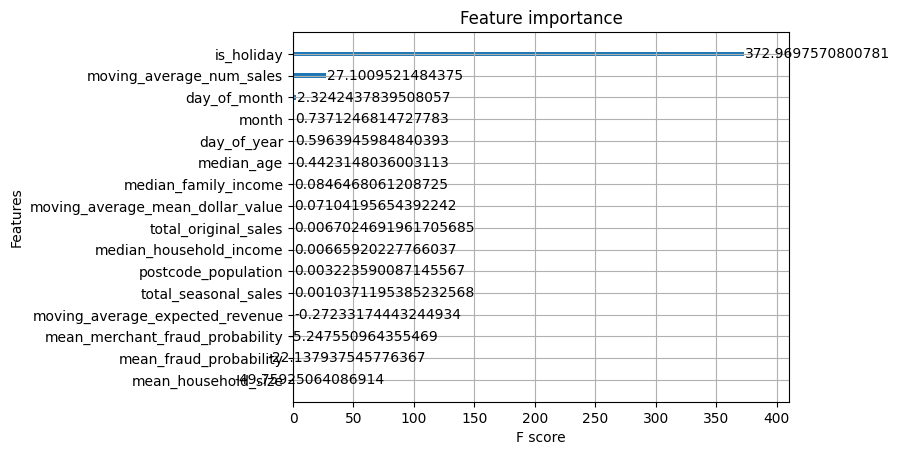

[ 2.32424e+00  5.96395e-01  3.72970e+02 -2.21379e+01 -4.97593e+01
 -5.24755e+00  4.42315e-01  8.46468e-02  6.65920e-03  7.37125e-01
 -2.72332e-01  7.10420e-02  2.71010e+01  3.22359e-03  6.70247e-03
  1.03712e-03]
['day_of_month' 'day_of_year' 'is_holiday' 'mean_fraud_probability'
 'mean_household_size' 'mean_merchant_fraud_probability' 'median_age'
 'median_family_income' 'median_household_income' 'month'
 'moving_average_expected_revenue' 'moving_average_mean_dollar_value'
 'moving_average_num_sales' 'postcode_population' 'total_original_sales'
 'total_seasonal_sales']


In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model.estimators_[0], importance_type='weight')
plt.show()

print(model.estimators_[0].coef_)
print(model.estimators_[0].feature_names_in_)

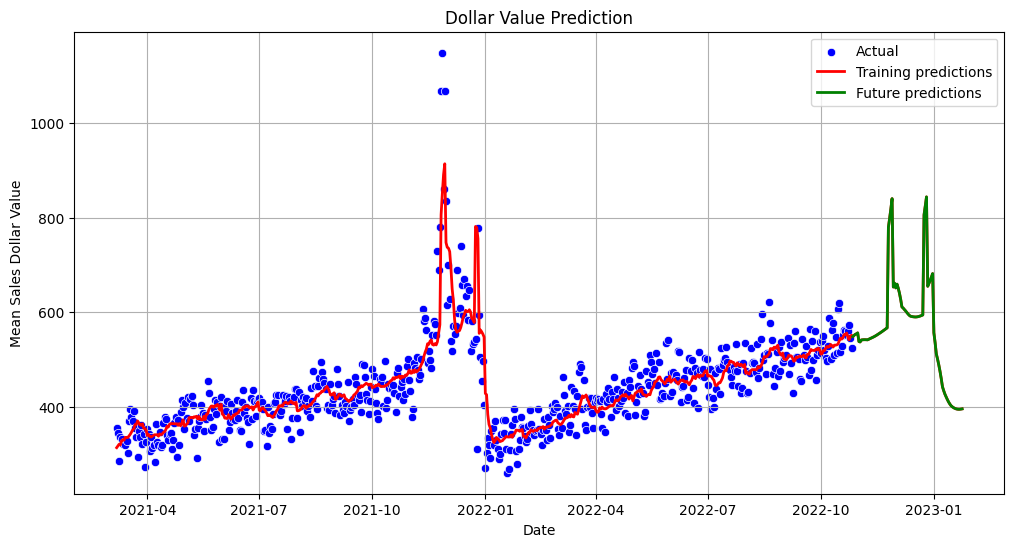

In [20]:
# Combine results and predictions dataframes to get merchant data, then plot the predictions for a merchant

merchant_abn = '89726005175'
graph_column = 'expected_revenue'

transactions = spark.read.parquet("../data/curated/transactions_preprocessed.parquet")
transactions = transactions.groupBy("merchant_abn", "order_datetime").agg(
    F.sum("expected_revenue").alias("expected_revenue"),
    F.mean("fraud_probability").alias("mean_fraud_probability"),
    F.mean("dollar_value").alias("mean_dollar_value"),
    F.count("merchant_abn").alias("num_sales"),
    F.first("tags").alias("tags"),
    F.first("take_rate").alias("take_rate"),
    F.mean("merchant_fraud_probability").alias("mean_merchant_fraud_probability"),
    F.mean("Median_age_persons").alias("median_age"),
    F.mean("Median_tot_fam_inc_weekly").alias("median_family_income"),
    F.mean("Median_tot_hhd_inc_weekly").alias("median_household_income"),
    F.mean("Average_household_size").alias("mean_household_size"),
    F.mean("Tot_P").alias("postcode_population"),
    F.first("day_of_week").alias("day_of_week"),
    F.first("day_of_month").alias("day_of_month"),
    F.first("day_of_year").alias("day_of_year"),
    F.first("month").alias("month"),
    F.first("year").alias("year"),
    F.mean("seasonal_sales").alias("seasonal_sales"),
    F.mean("original_sales").alias("original_sales"),
    F.first("total_seasonal_sales").alias("total_seasonal_sales"),
    F.first("total_original_sales").alias("total_original_sales"),
    F.first("is_holiday").alias("is_holiday"),
)
transactions = transactions.sort(F.col("order_datetime"), F.col("merchant_abn"))
transactions = transactions.where(F.col("merchant_abn") == merchant_abn).toPandas()

training_results = spark.read.option("header", "true").csv("results.csv")
training_results = training_results.drop(training_results.columns[0])

predictions = spark.read.option("header", "true").csv("predictions.csv")
predictions = predictions.drop(predictions.columns[0])

results = predictions.join(training_results, on='merchant_abn', how='inner')
results = results.select(*[F.col(column).cast(DoubleType()).alias(column) if column not in ['order_datetime', 'merchant_abn'] else F.col(column) for column in results.columns])
results = results.join(tbl_merchants, on='merchant_abn', how='left')

merchant_stats = spark.read.parquet("../data/curated/transactions_preprocessed.parquet").groupBy('merchant_abn').agg(
    F.mean("merchant_fraud_probability").alias("merchant_mean_merchant_fraud_probability"),
    F.mean("fraud_probability").alias("merchant_mean_consumer_fraud_probability"),
    skewness_udf(F.col("dollar_value")).alias("dollar_value_skewness"),
    F.mean("dollar_value").alias("merchant_mean_dollar_value"),
    F.mean("expected_revenue").alias("merchant_mean_expected_revenue"),
)
results = results.join(merchant_stats, on='merchant_abn', how='left')


expected_revenue_columns = ','.join([f"`{graph_column}|{i}`" for i in range(prediction_period)])


merchant_results = results.where(F.col("merchant_abn") == merchant_abn).selectExpr(
    f"stack(90, {expected_revenue_columns}) as (predicted)"
).toPandas()

merchant_results['order_datetime'] = pd.date_range(
    transactions['order_datetime'].values[-1] + pd.Timedelta(days=1), 
    transactions['order_datetime'].values[-1] + pd.Timedelta(days=90), 
)

df = transactions

df = create_lagged_features(df, n_lags, 'expected_revenue')
df = create_lagged_features(df, n_lags, 'num_sales')
df = create_lagged_features(df, n_lags, 'mean_dollar_value')
df = lag_feature(df, 1, 'median_household_income')
df = lag_feature(df, 1, 'mean_merchant_fraud_probability')
df = lag_feature(df, 1, 'mean_fraud_probability')

df = df.iloc[n_lags:]
df = df[DATA_COLUMNS]
df = df.sort_index(axis=1)

X = df.drop(PREDICTION_COLUMNS + ['order_datetime'], axis=1)
y = df[PREDICTION_COLUMNS]

model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, booster='gblinear'))
model.fit(X, y)

df['predicted'] = model.predict(X)[:, PREDICTION_COLUMNS.index(graph_column)]
df = pd.concat([df, merchant_results])
df['order_datetime'] = pd.to_datetime(df['order_datetime'])
df = df.sort_values(by='order_datetime')
df['predicted'] = df['predicted'].astype(np.float64)

def plot_predictions(data, title='Revenue Prediction', y_label='Expected Revenue'):
    plt.figure(figsize=(12, 6))

    sns.scatterplot(data.iloc[:-prediction_period], x='order_datetime', y=graph_column, label='Actual', color='blue')
    ax = sns.lineplot(data, x='order_datetime', y='predicted', label='Training predictions', color='red', linewidth=2)
    ax = sns.lineplot(data.tail(prediction_period), x='order_datetime', y='predicted', label='Future predictions', color='green', linewidth=2)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()

plot_predictions(df, "Dollar Value Prediction", "Mean Sales Dollar Value")

/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_97508/3452960614.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


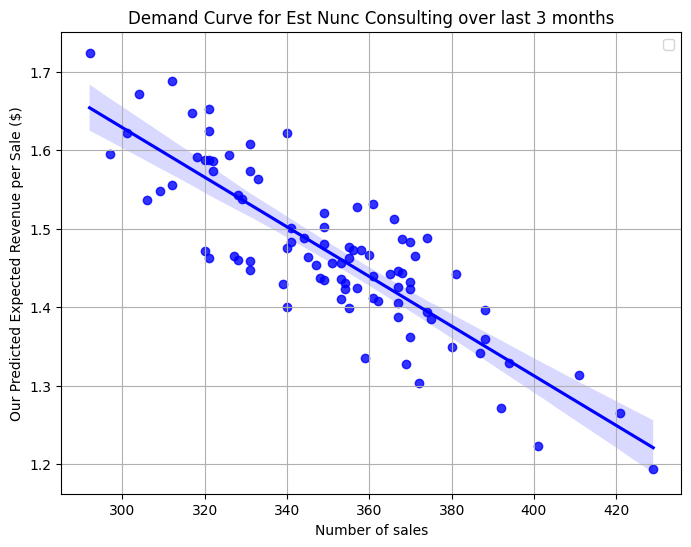

                            OLS Regression Results                            
Dep. Variable:              num_sales   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     225.9
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           5.01e-26
Time:                        00:38:08   Log-Likelihood:                -367.59
No. Observations:                  90   AIC:                             739.2
Df Residuals:                      88   BIC:                             744.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [21]:
# Make a demand curve for this merchant

import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.figure(figsize=(8, 6))
df['expected_revenue_per_sale'] = df['predicted'] / df['num_sales']
sns.regplot(df[-prediction_period * 2:-prediction_period], x='num_sales', y='expected_revenue_per_sale', color='blue', fit_reg=True)

# plt.scatter(df[-180:]['num_sales'], df.iloc[-180:]['predicted'] / df.iloc[-180:]['num_sales'], color='blue')
plt.title("Demand Curve for Est Nunc Consulting over last 3 months")
plt.xlabel('Number of sales')
plt.ylabel('Our Predicted Expected Revenue per Sale ($)')
plt.legend()
plt.grid()
plt.show()

model = smf.ols('num_sales ~ expected_revenue_per_sale', data=df[-prediction_period * 2:-prediction_period]).fit()
print(model.summary())

In [102]:
# Select key columns to include in ranked merchant results
ranked_merchants = results.select(
    # Merchant details
    "merchant_abn",
    "merchant_name",
    "merchant_mean_merchant_fraud_probability",
    "merchant_mean_consumer_fraud_probability",
    "dollar_value_skewness",
    "tags",
    "type",

    # The following are the coefficients learned by the model
    "merchant_mean_dollar_value",
    "merchant_mean_expected_revenue",
    "take_rate",
    "day_of_month",
    "day_of_year",
    "is_holiday",
    "mean_fraud_probability",
    "mean_household_size",
    "mean_merchant_fraud_probability",
    "median_age",
    "median_family_income",
    "median_household_income",
    "month",
    "moving_average_expected_revenue",
    "moving_average_mean_dollar_value",
    "moving_average_num_sales",
    "postcode_population",
    "total_original_sales",
    "total_seasonal_sales",

    # Testing and validation scores
    "std_val_score",
    "test_rmse",
    "val_rmse",

    # Future predictions summed
    "num_sales_predicted_sum",
    "mean_dollar_value_predicted_sum",
    "expected_revenue_predicted_sum",
).sort(F.col("expected_revenue_predicted_sum").desc())

ranked_merchants.show(100, truncate=False)
ranked_merchants.write.mode("overwrite").csv("top_100.csv")

+------------+---------------------------------+----------------------------------------+----------------------------------------+----------------------+--------------------------+------------------------------+----------------------------------------------------------------+----+---------+------------+-----------+----------+----------------------+-------------------+-------------------------------+-----------+--------------------+-----------------------+---------+-------------------------------+--------------------------------+------------------------+-------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------------+-------------------------------+------------------------------+
|merchant_abn|merchant_name                    |merchant_mean_merchant_fraud_probability|merchant_mean_consumer_fraud_probability|dollar_value_skewness |merchant_mean_dollar_value|merchant_mean_expected_revenue|tags                   

In [238]:
window_spec = Window.orderBy(F.desc("expected_revenue_predicted_sum"))
ranked_merchants = ranked_merchants.withColumn("row_num", F.row_number().over(window_spec))
ranked_merchants.select('row_num', 'merchant_abn', 'expected_revenue_predicted_sum').show(100)

24/10/09 21:36:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/09 21:36:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/09 21:36:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/09 21:36:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/09 21:36:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/09 21:36:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/09 2

+-------+------------+------------------------------+
|row_num|merchant_abn|expected_revenue_predicted_sum|
+-------+------------+------------------------------+
|      1| 79827781481|             62673.40005493164|
|      2| 48534649627|            61505.107513427734|
|      3| 86578477987|             59377.41116333008|
|      4| 38700038932|            58785.243713378906|
|      5| 32361057556|             57547.63864135742|
|      6| 96680767841|            56324.977966308594|
|      7| 45629217853|            55785.147552490234|
|      8| 21439773999|             55397.76483154297|
|      9| 64403598239|              53897.3879699707|
|     10| 63123845164|            52532.907287597656|
|     11| 89726005175|             50741.66583251953|
|     12| 82368304209|             50673.07098388672|
|     13| 49322182190|             49028.14370727539|
|     14| 94493496784|             48955.41668701172|
|     15| 35909341340|             44743.05987548828|
|     16| 72472909171|      

24/10/09 21:36:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/09 21:36:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/09 21:36:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/09 21:37:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/09 21:37:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/09 21:37:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/09 2

24/10/12 05:30:08 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 959790 ms exceeds timeout 120000 ms
24/10/12 05:30:09 WARN SparkContext: Killing executors is not supported by current scheduler.
24/10/12 05:30:18 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [220]:
clustered_results = results.join(clusters, on='merchant_abn', how='left').select(
    "merchant_abn",
    "merchant_name",
    "merchant_mean_merchant_fraud_probability",
    "merchant_mean_consumer_fraud_probability",
    "dollar_value_skewness",
    "merchant_mean_dollar_value",
    "merchant_mean_expected_revenue",
    "tags",
    "type",
    "take_rate",
    "day_of_month",
    "day_of_year",
    "is_holiday",
    "mean_fraud_probability",
    "mean_household_size",
    "mean_merchant_fraud_probability",
    "median_age",
    "median_family_income",
    "median_household_income",
    "month",
    "moving_average_expected_revenue",
    "moving_average_mean_dollar_value",
    "moving_average_num_sales",
    "postcode_population",
    "total_original_sales",
    "total_seasonal_sales",
    "std_val_score",
    "test_rmse",
    "val_rmse",
    "num_sales_predicted_sum",
    "mean_dollar_value_predicted_sum",
    "expected_revenue_predicted_sum",
    "cluster",
).sort(F.col("expected_revenue_predicted_sum").desc())
clustered_results.where(F.col("cluster") == 0).show()
clustered_results.where(F.col("cluster") == 1).show()
clustered_results.where(F.col("cluster") == 2).show()

+------------+-------------+----------------------------------------+----------------------------------------+---------------------+--------------------------+------------------------------+----+----+---------+------------+-----------+----------+----------------------+-------------------+-------------------------------+----------+--------------------+-----------------------+-----+-------------------------------+--------------------------------+------------------------+-------------------+--------------------+--------------------+-------------+---------+--------+-----------------------+-------------------------------+------------------------------+-------+
|merchant_abn|merchant_name|merchant_mean_merchant_fraud_probability|merchant_mean_consumer_fraud_probability|dollar_value_skewness|merchant_mean_dollar_value|merchant_mean_expected_revenue|tags|type|take_rate|day_of_month|day_of_year|is_holiday|mean_fraud_probability|mean_household_size|mean_merchant_fraud_probability|median_age|medi

+------------+-------------+----------------------------------------+----------------------------------------+---------------------+--------------------------+------------------------------+----+----+---------+------------+-----------+----------+----------------------+-------------------+-------------------------------+----------+--------------------+-----------------------+-----+-------------------------------+--------------------------------+------------------------+-------------------+--------------------+--------------------+-------------+---------+--------+-----------------------+-------------------------------+------------------------------+-------+
|merchant_abn|merchant_name|merchant_mean_merchant_fraud_probability|merchant_mean_consumer_fraud_probability|dollar_value_skewness|merchant_mean_dollar_value|merchant_mean_expected_revenue|tags|type|take_rate|day_of_month|day_of_year|is_holiday|mean_fraud_probability|mean_household_size|mean_merchant_fraud_probability|median_age|medi

+------------+-------------+----------------------------------------+----------------------------------------+---------------------+--------------------------+------------------------------+----+----+---------+------------+-----------+----------+----------------------+-------------------+-------------------------------+----------+--------------------+-----------------------+-----+-------------------------------+--------------------------------+------------------------+-------------------+--------------------+--------------------+-------------+---------+--------+-----------------------+-------------------------------+------------------------------+-------+
|merchant_abn|merchant_name|merchant_mean_merchant_fraud_probability|merchant_mean_consumer_fraud_probability|dollar_value_skewness|merchant_mean_dollar_value|merchant_mean_expected_revenue|tags|type|take_rate|day_of_month|day_of_year|is_holiday|mean_fraud_probability|mean_household_size|mean_merchant_fraud_probability|median_age|medi

In [200]:
clustered_results.where(F.col("cluster") == 0).select(
    'merchant_abn', 
    'merchant_name', 
    F.col('mean_dollar_value_predicted_sum') / 90.0, 
    F.col('num_sales_predicted_sum') / 90,
    'expected_revenue_predicted_sum', 
).write.mode('overwrite').csv('0.csv')
clustered_results.where(F.col("cluster") == 1).select(
    'merchant_abn', 
    'merchant_name', 
    F.col('mean_dollar_value_predicted_sum') / 90.0, 
    F.col('num_sales_predicted_sum') / 90,
    'expected_revenue_predicted_sum', 
).write.mode('overwrite').csv('1.csv')
clustered_results.where(F.col("cluster") == 2).select(
    'merchant_abn', 
    'merchant_name', 
    F.col('mean_dollar_value_predicted_sum') / 90.0, 
    F.col('num_sales_predicted_sum') / 90,
    'expected_revenue_predicted_sum', 
).write.mode('overwrite').csv('2.csv')
# clustered_results.where(F.col("cluster") == 1).select('merchant_abn', 'merchant_name', 'expected_revenue_predicted_sum').show(5, truncate=False)
# clustered_results.where(F.col("cluster") == 2).select('merchant_abn', 'merchant_name', 'expected_revenue_predicted_sum').show(5, truncate=False)

+------------+--------------------+----------------------------------------+----------------------------------------+---------------------+--------------------------+------------------------------+--------------------+----+---------+------------+-----------+----------+----------------------+-------------------+-------------------------------+----------+--------------------+-----------------------+---------+-------------------------------+--------------------------------+------------------------+-------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------------+-------------------------------+------------------------------+--------------------+
|merchant_abn|       merchant_name|merchant_mean_merchant_fraud_probability|merchant_mean_consumer_fraud_probability|dollar_value_skewness|merchant_mean_dollar_value|merchant_mean_expected_revenue|                tags|type|take_rate|day_of_month|day_of_year|is_holiday|mea

/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_68774/3602701584.py:10: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.kdeplot(best_clustered, x='expected_revenue_predicted_sum', hue='cluster', palette=sns.color_palette(), fill=True, bw_adjust=0.5)


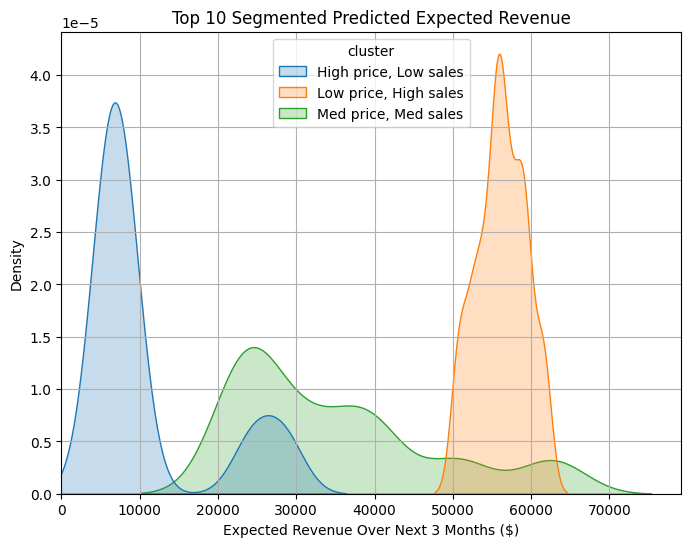

In [228]:
# clustered_results.show()
window_spec = Window.partitionBy("cluster").orderBy(F.desc("expected_revenue_predicted_sum"))
row_df = clustered_results.withColumn("row_num", F.row_number().over(window_spec))
best_clustered = row_df.filter(row_df.row_num <= 10).drop("row_num")
# best_clustered['merchant_mean_dollar_value']
# sns.scatterplot(best_clustered, x='', y='')
best_clustered.show(1000)
best_clustered = best_clustered.toPandas()
plt.figure(figsize=(8, 6))
sns.kdeplot(best_clustered, x='expected_revenue_predicted_sum', hue='cluster', palette=sns.color_palette(), fill=True, bw_adjust=0.5)
plt.title("Top 10 Segmented Predicted Expected Revenue")
plt.xlabel("Expected Revenue Over Next 3 Months ($)")
plt.ylabel("Density")
plt.xlim(0)
plt.grid()


+------------+--------------------+----------------------------------------+----------------------------------------+---------------------+--------------------------+------------------------------+--------------------+----+---------+------------+-----------+----------+----------------------+-------------------+-------------------------------+----------+--------------------+-----------------------+---------+-------------------------------+--------------------------------+------------------------+-------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------------+-------------------------------+------------------------------+--------------------+
|merchant_abn|       merchant_name|merchant_mean_merchant_fraud_probability|merchant_mean_consumer_fraud_probability|dollar_value_skewness|merchant_mean_dollar_value|merchant_mean_expected_revenue|                tags|type|take_rate|day_of_month|day_of_year|is_holiday|mea

/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_68774/2909433199.py:10: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.kdeplot(best_clustered, x='test_rmse', hue='cluster', palette=sns.color_palette(), fill=True, bw_adjust=0.5)


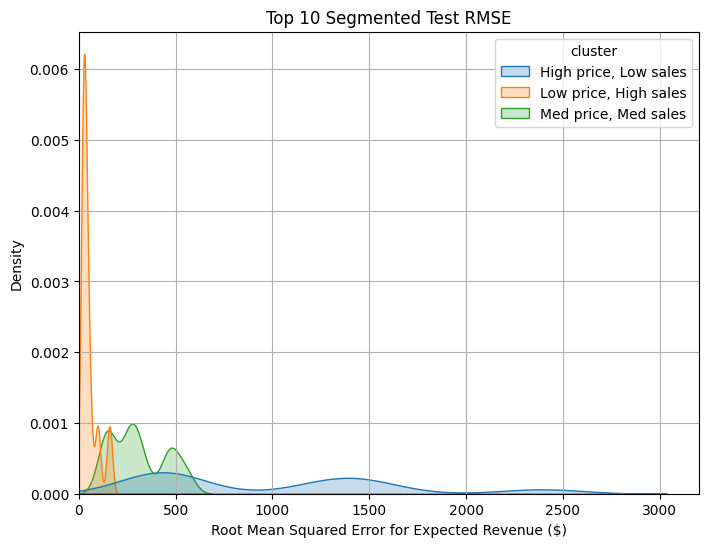

In [231]:
# clustered_results.show()
window_spec = Window.partitionBy("cluster").orderBy(F.desc("expected_revenue_predicted_sum"))
row_df = clustered_results.withColumn("row_num", F.row_number().over(window_spec))
best_clustered = row_df.filter(row_df.row_num <= 10).drop("row_num")
# best_clustered['merchant_mean_dollar_value']
# sns.scatterplot(best_clustered, x='', y='')
best_clustered.show(100)
best_clustered = best_clustered.toPandas()
plt.figure(figsize=(8, 6))
sns.kdeplot(best_clustered, x='test_rmse', hue='cluster', palette=sns.color_palette(), fill=True, bw_adjust=0.5)
plt.title("Top 10 Segmented Test RMSE")
plt.xlabel("Root Mean Squared Error for Expected Revenue ($)")
plt.ylabel("Density")
plt.xlim(0)
plt.grid()


In [236]:
best_clustered = row_df.filter(row_df.row_num <= 10).select('merchant_abn', 'row_num', 'expected_revenue_predicted_sum', 'cluster')
best_clustered.show(100)

+------------+-------+------------------------------+--------------------+
|merchant_abn|row_num|expected_revenue_predicted_sum|             cluster|
+------------+-------+------------------------------+--------------------+
| 31334588839|      1|            28444.067352294922|High price, Low s...|
| 19492220327|      2|            24387.230682373047|High price, Low s...|
| 90918180829|      3|             8483.027931213379|High price, Low s...|
| 83199298021|      4|             8107.491165161133|High price, Low s...|
| 15043504837|      5|             7275.490550994873|High price, Low s...|
| 12741443840|      6|             7170.174125671387|High price, Low s...|
| 88539253623|      7|             6842.823440551758|High price, Low s...|
| 73918814753|      8|             5791.225250244141|High price, Low s...|
| 55402538421|      9|             5725.766983032227|High price, Low s...|
| 98627514823|     10|             5531.885845184326|High price, Low s...|
| 48534649627|      1|   

24/10/08 20:27:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/08 20:27:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/08 20:27:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/08 20:27:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/08 20:27:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/08 20:27:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/08 2

<Figure size 800x600 with 0 Axes>

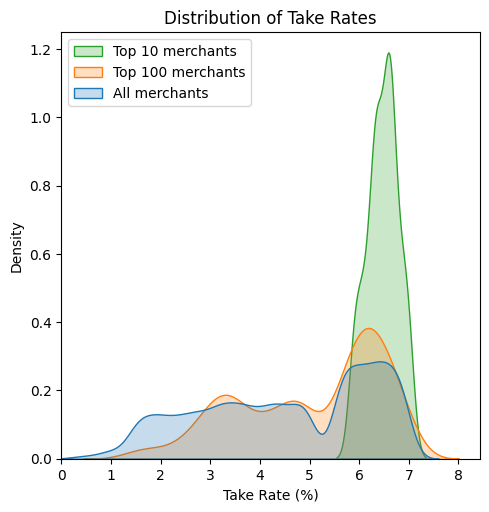

In [18]:
from pyspark.sql import Window

window_spec = Window.orderBy("expected_revenue_predicted_sum")
removed_fraud = ranked_merchants.where(F.col("merchant_mean_merchant_fraud_probability") < 50.0)

removed_fraud = removed_fraud.withColumn("row_num", F.row_number().over(window_spec)) \
    .withColumn("is_first_100", F.when(F.col("row_num") <= 100, 1).otherwise(0)) \
    .drop("row_num")

removed_fraud = removed_fraud.withColumn("row_num", F.row_number().over(window_spec)) \
    .withColumn("is_first_10", F.when(F.col("row_num") <= 10, 1).otherwise(0)) \
    .drop("row_num")

removed_fraud = removed_fraud.sort(F.col("expected_revenue_predicted_sum").desc()).toPandas()

all_merchants = removed_fraud.copy()
all_merchants['subset'] = 'All merchants'

top_100_merchants = removed_fraud.iloc[:100].copy()
top_100_merchants['subset'] = 'Top 100 merchants'

top_10_merchants = removed_fraud.iloc[:10].copy()
top_10_merchants['subset'] = 'Top 10 merchants'

merged_data = pd.concat([all_merchants, top_100_merchants, top_10_merchants])

plt.figure(figsize=(8, 6), frameon=False)
ax = sns.displot(data=merged_data, x='take_rate', hue="subset", bw_adjust=0.6, kind="kde", common_norm=False, legend=False, fill=True)
# sns.move_legend(ax, "upper center")

ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Take Rates")
plt.legend(['Top 10 merchants', 'Top 100 merchants', 'All merchants'], loc="upper left")
plt.xlabel("Take Rate (%)")
plt.ylabel("Density")
# plt.xlim((0, 7.5))
plt.xlim(0)

plt.show()

<Figure size 800x600 with 0 Axes>

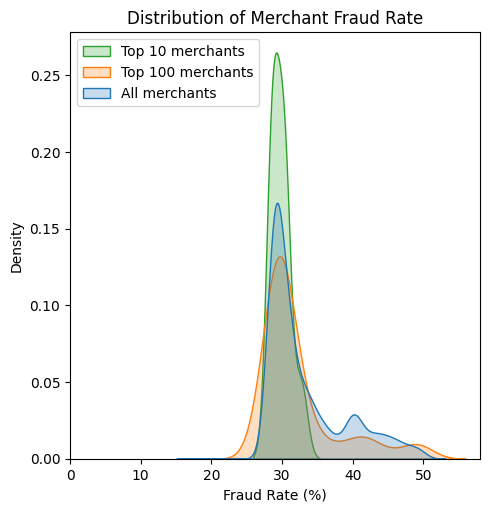

In [19]:
all_merchants = removed_fraud.copy()
all_merchants['subset'] = 'All merchants'

top_100_merchants = removed_fraud.iloc[:100].copy()
top_100_merchants['subset'] = 'Top 100 merchants'

top_10_merchants = removed_fraud.iloc[:10].copy()
top_10_merchants['subset'] = 'Top 10 merchants'

merged_data = pd.concat([all_merchants, top_100_merchants, top_10_merchants])

plt.figure(figsize=(8, 6), frameon=False)
ax = sns.displot(data=merged_data, x='merchant_mean_merchant_fraud_probability', hue="subset", bw_adjust=1, kind="kde", common_norm=False, legend=False, fill=True)
# sns.move_legend(ax, "upper center")

ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Merchant Fraud Rate")
plt.legend(['Top 10 merchants', 'Top 100 merchants', 'All merchants'], loc="upper left")
plt.xlabel("Fraud Rate (%)")
plt.ylabel("Density")
# plt.xlim((0, 7.5))
plt.xlim(0)

plt.show()


<Figure size 800x600 with 0 Axes>

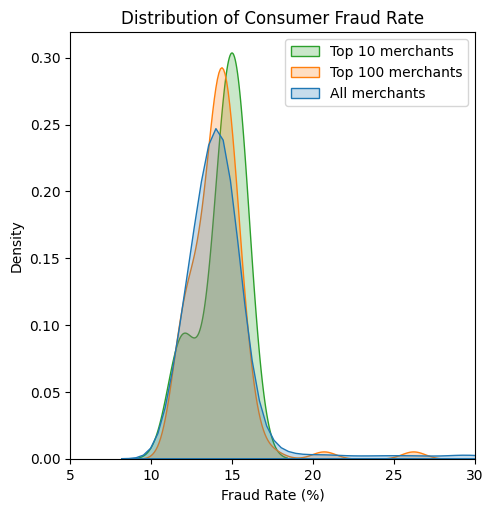

In [32]:
all_merchants = removed_fraud.copy()
all_merchants['subset'] = 'All merchants'

top_100_merchants = removed_fraud.iloc[:100].copy()
top_100_merchants['subset'] = 'Top 100 merchants'

top_10_merchants = removed_fraud.iloc[:10].copy()
top_10_merchants['subset'] = 'Top 10 merchants'

merged_data = pd.concat([all_merchants, top_100_merchants, top_10_merchants])

plt.figure(figsize=(8, 6), frameon=False)
ax = sns.displot(data=merged_data, x='merchant_mean_consumer_fraud_probability', hue="subset", bw_adjust=1, kind="kde", common_norm=False, legend=False, fill=True)
# sns.move_legend(ax, "upper center")

ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Consumer Fraud Rate")
plt.legend(['Top 10 merchants', 'Top 100 merchants', 'All merchants'], loc="upper right")
plt.xlabel("Fraud Rate (%)")
plt.ylabel("Density")
plt.xlim((5, 30))
# plt.xlim(0)

plt.show()

<Figure size 800x600 with 0 Axes>

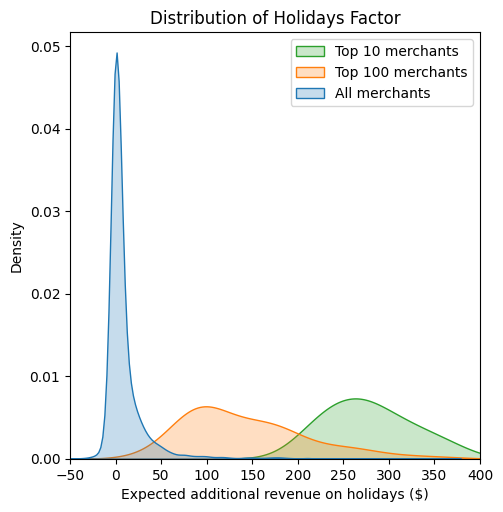

In [57]:

removed_fraud['proportion_holidays'] = removed_fraud['is_holiday'] / (removed_fraud['expected_revenue_predicted_sum'] / 90.0)

all_merchants = removed_fraud.copy()
all_merchants['subset'] = 'All merchants'

top_100_merchants = removed_fraud.iloc[:100].copy()
top_100_merchants['subset'] = 'Top 100 merchants'

top_10_merchants = removed_fraud.iloc[:10].copy()
top_10_merchants['subset'] = 'Top 10 merchants'

merged_data = pd.concat([all_merchants, top_100_merchants, top_10_merchants])

plt.figure(figsize=(8, 6), frameon=False)
ax = sns.displot(data=merged_data, x='is_holiday', hue="subset", bw_adjust=1, kind="kde", common_norm=False, legend=False, fill=True)
# sns.move_legend(ax, "upper center")

ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Holidays Factor")
plt.legend(['Top 10 merchants', 'Top 100 merchants', 'All merchants'], loc="upper right")
plt.xlabel("Expected additional revenue on holidays ($)")
plt.ylabel("Density")
plt.xlim((-50, 400))
# plt.xlim((-1, 2))

plt.show()